In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, diags, eye
from sklearn.cluster.bicluster import SpectralBiclustering, SpectralCoclustering

%matplotlib inline

In [2]:
df = pd.read_csv("./facebook_combined.txt.gz", compression='infer', sep=" ")
print(len(df))
df.head()

88233


,0,1
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


In [3]:
e = len(df)
v = len(np.unique(df["0"]))
v = max(np.max(np.unique(df["0"])), np.max(np.unique(df["1"]))) + 1
print(e,v)

facebook = csr_matrix((np.ones(e), (df['0'], df['1'])), shape=(v,v))
%time facebook = facebook + facebook.T + eye(v)
facebook

88233 4039
CPU times: user 9.99 ms, sys: 1.5 ms, total: 11.5 ms
Wall time: 13 ms


<4039x4039 sparse matrix of type '<class 'numpy.float64'>'
	with 180505 stored elements in Compressed Sparse Row format>

In [4]:
n_clusters = int(v/20)

cl1 = SpectralCoclustering(n_clusters = n_clusters, n_jobs=2, svd_method='arpack', n_init=30)
%time cl1.fit(facebook)

CPU times: user 536 ms, sys: 543 ms, total: 1.08 s
Wall time: 15.2 s


In [5]:
indices = [len(cl1.get_indices(i)[0]) for i in range(cl1.n_clusters)]

print(indices[:20])
print(np.mean(indices), np.std(indices), np.min(indices), np.max(indices))

[53, 7, 26, 91, 70, 16, 39, 22, 14, 22, 13, 1, 37, 38, 1, 9, 1, 1, 2, 124]
20.0945273632 34.4981940533 1 233


In [6]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

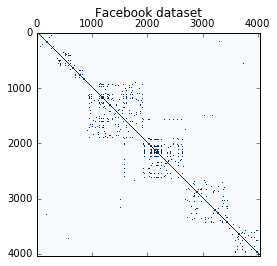

In [7]:
plt.matshow(facebook.toarray(), cmap=plt.cm.Blues)
plt.title("Facebook dataset")

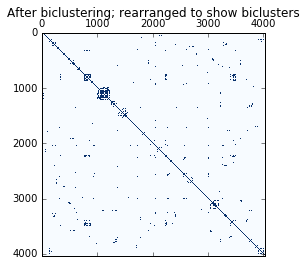

In [8]:
fit_data = facebook.toarray()[np.argsort(cl1.row_labels_)]
fit_data = fit_data[:, np.argsort(cl1.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

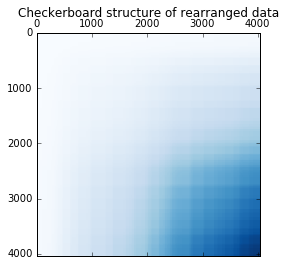

In [9]:
plt.matshow(np.outer(np.sort(cl1.row_labels_) + 1,
                     np.sort(cl1.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")

In [10]:
cl1.row_labels_

array([  2,  92, 109, ..., 142, 142,  67], dtype=int32)

In [11]:
import networkx as nx
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

In [12]:
x = np.array(df.to_records(index=False))
l = [(a,b) for a,b in x]
l[:10]

[(0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11)]

In [13]:
%time g = nx.Graph([(a,b) for a,b in df.to_records(index=False)])
g

CPU times: user 1.05 s, sys: 45.6 ms, total: 1.09 s
Wall time: 1.11 s


13 13
(array([579, 589, 592, 612, 617, 621, 622, 636, 654, 672, 677, 680, 685]), array([579, 589, 592, 612, 617, 621, 622, 636, 654, 672, 677, 680, 685]))


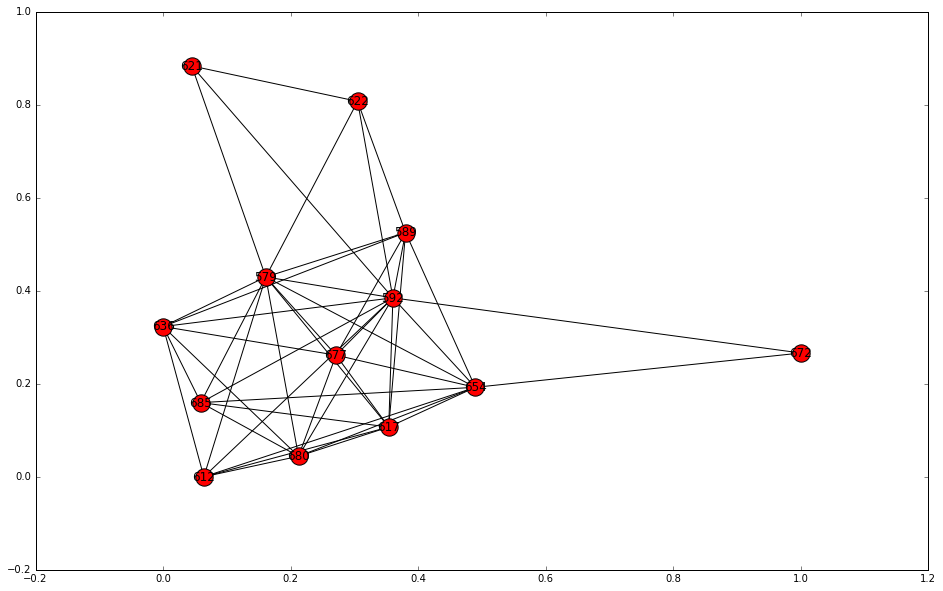

In [18]:
ind = cl1.get_indices(10)
print (len(ind[0]), len(ind[1]))
print(ind)
sub = g.subgraph(ind[0])

nx.draw_networkx(sub)

In [21]:
l = 621
print(df[df["0"]==l])
print(df[df["1"]==l])

        0    1
9177  621  622
9178  621  663
        0    1
6152  414  621
8551  574  621
8636  579  621
8826  592  621
9119  616  621


## Passage au Laplacien

In [22]:
facebook2 = csr_matrix((np.ones(e), (df['0'], df['1'])), shape=(v,v))
facebook2 = facebook2 + facebook2.T

In [43]:
np.array(facebook2.sum(axis=0))[0]

array([ 346.,   16.,   10., ...,    2.,    4.,    9.])

In [45]:
L = diags(np.array(facebook2.sum(axis=0))[0]) - facebook2
L

<4039x4039 sparse matrix of type '<class 'numpy.float64'>'
	with 180505 stored elements in Compressed Sparse Row format>

In [46]:
from scipy.sparse.linalg import eigsh

In [65]:
n_clusters = int(L.shape[0]/20)
neig = 2 + int(np.log(n_clusters) / np.log(2))
print(n_clusters, neig)

%time eigval, eigvec = eigsh(L, neig, which='SM', tol=1e-3)
eigval

201 9
CPU times: user 1.5 s, sys: 1.24 s, total: 2.74 s
Wall time: 1.63 s


array([  6.71300757e-14,   1.81476472e-02,   2.89880331e-02,
         4.71877939e-02,   6.82694179e-02,   1.10552279e-01,
         1.63108060e-01,   6.78447046e-01,   7.33054089e-01])

In [66]:
eigvec

array([[ -1.57348669e-02,   7.97673453e-03,  -4.15270952e-03, ...,
          4.41631275e-03,   2.34310747e-04,  -2.22569763e-07],
       [ -1.57348669e-02,   7.99488788e-03,  -4.16993461e-03, ...,
          3.94887944e-03,   1.95402439e-04,  -3.01719034e-07],
       [ -1.57348669e-02,   8.12166851e-03,  -4.27463018e-03, ...,
          5.23975854e-03,   6.94311255e-04,  -6.10593295e-07],
       ..., 
       [ -1.57348669e-02,   1.28883042e-02,   1.30377533e-01, ...,
         -5.70757092e-03,   2.00720229e-03,   3.12441740e-06],
       [ -1.57348669e-02,   1.27791859e-02,   1.28602815e-01, ...,
         -5.23292296e-03,   9.73707454e-04,   1.25064984e-06],
       [ -1.57348669e-02,   1.24889377e-02,   1.23915741e-01, ...,
         -4.09052674e-03,  -5.75657588e-04,  -1.46728115e-06]])

In [67]:
e1 = eigvec[:,1]
print((e1>=0).sum(), (e1<0).sum())

3285 754


(2, 4039)


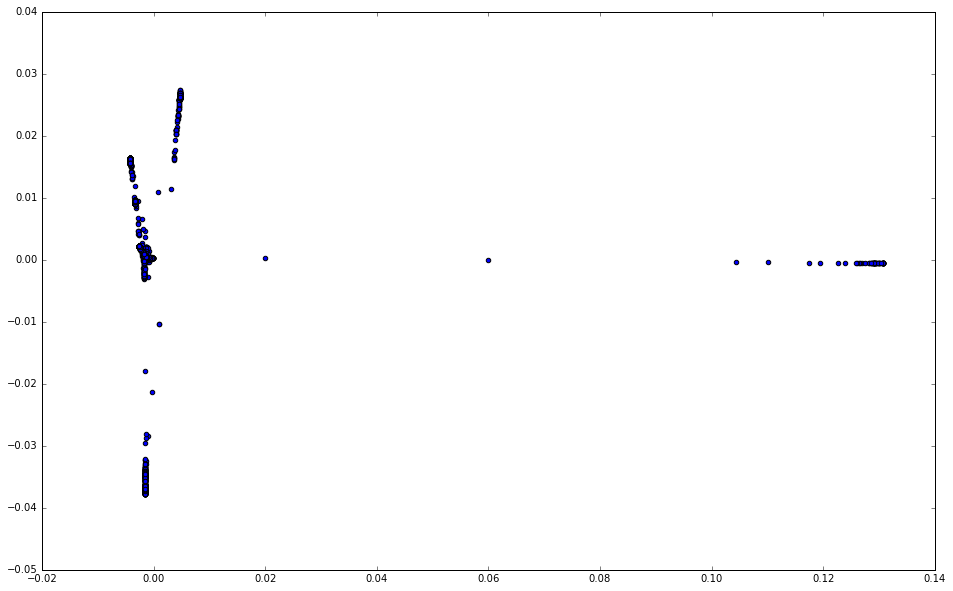

In [74]:
proj = eigvec[:, 2:4].T
print(proj.shape)

colour = np.array()

plt.scatter(proj[0], proj[1])